<a href="https://colab.research.google.com/github/pakkei1212/SMU_AML_PROJ/blob/decision_trees/Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import optuna

In [3]:
df = pd.read_csv('hotel_data_cleaned.csv')

In [4]:
print(df.columns)

Index(['is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest',
       ...
       'country_binned_ITA', 'country_binned_NLD', 'country_binned_Other',
       'country_binned_PRT', 'agent_binned_7.0', 'agent_binned_9.0',
       'agent_binned_14.0', 'agent_binned_240.0', 'agent_binned_Not Specified',
       'agent_binned_Other'],
      dtype='object', length=101)


In [5]:
def train_val_test_split(df, use_time_split=True):
    """
    Split the dataset into train, val, test.

    If use_time_split=True:
        - Train: before last 6 months
        - Val: between 3-6 months before max date
        - Test: last 3 months

    If use_time_split=False:
        - Random 80% train_val, 20% test (with stratified y split)

    Returns:
        (X_train, y_train), (X_val, y_val), (X_test, y_test)
    """
    from sklearn.model_selection import train_test_split

    drop_cols = ['arrival_date', 'is_canceled']

    if use_time_split:
        df['arrival_date'] = pd.to_datetime(df['arrival_date'])
        df = df.sort_values("arrival_date")

        latest_date = df['arrival_date'].max()
        test_cutoff = latest_date - pd.DateOffset(months=3)
        val_cutoff = latest_date - pd.DateOffset(months=6)

        df_train = df[df['arrival_date'] < val_cutoff]
        df_val = df[(df['arrival_date'] >= val_cutoff) & (df['arrival_date'] < test_cutoff)]
        df_test = df[df['arrival_date'] >= test_cutoff]

        X_train = df_train.drop(columns=drop_cols)
        y_train = df_train['is_canceled']
        X_val = df_val.drop(columns=drop_cols)
        y_val = df_val['is_canceled']
        X_test = df_test.drop(columns=drop_cols)
        y_test = df_test['is_canceled']

    else:
        # Random split: 80% train_val, 20% test
        X = df.drop(columns=drop_cols)
        y = df['is_canceled']

        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=0.2, random_state=2025, stratify=y, shuffle=True
        )
        # Optional: create validation split from train_val
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=0.25, random_state=2025, stratify=y_train_val
        )  # 0.25 × 0.8 = 0.2 of total for val

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# For time-based split
(X_train, y_train), (X_val, y_val), (X_test, y_test) = train_val_test_split(df, use_time_split=True)

# For random split
# (X_train, y_train), (X_val, y_val), (X_test, y_test) = train_val_test_split(df, use_time_split=False)

In [6]:
# Use Optuna to tune the decision tree
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0, 0.05)
    }
    model = DecisionTreeClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    y_val_pred = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_val_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best hyperparameters:", study.best_params)

[I 2025-06-07 12:13:13,619] A new study created in memory with name: no-name-94fb6ba8-d285-4705-be01-333f380f1e07
[I 2025-06-07 12:13:14,485] Trial 0 finished with value: 0.6800227164191771 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 15, 'ccp_alpha': 0.004584952768129341}. Best is trial 0 with value: 0.6800227164191771.
[I 2025-06-07 12:13:15,457] Trial 1 finished with value: 0.7775450532706959 and parameters: {'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 3, 'ccp_alpha': 0.01103525541495647}. Best is trial 1 with value: 0.7775450532706959.
[I 2025-06-07 12:13:15,753] Trial 2 finished with value: 0.6336940615995998 and parameters: {'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 20, 'ccp_alpha': 0.013791066169092998}. Best is trial 1 with value: 0.7775450532706959.
[I 2025-06-07 12:13:16,405] Trial 3 finished with value: 0.7775450532706959 and parameters: {'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 17, 'ccp_al

Best hyperparameters: {'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 4, 'ccp_alpha': 1.7887120609303428e-05}


In [7]:
# Train best model on combined train+val
X_final_train = pd.concat([X_train, X_val])
y_final_train = pd.concat([y_train, y_val])

final_model = DecisionTreeClassifier(**study.best_params, random_state=42)
final_model.fit(X_final_train, y_final_train)

DecisionTreeClassifier(ccp_alpha=1.7887120609303428e-05, max_depth=8,
                       min_samples_leaf=4, min_samples_split=17,
                       random_state=42)

In [8]:
# Evaluate on test set
y_test_probs = final_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_test_probs)
print(f"Test AUC: {auc:.4f}")

Test AUC: 0.8419


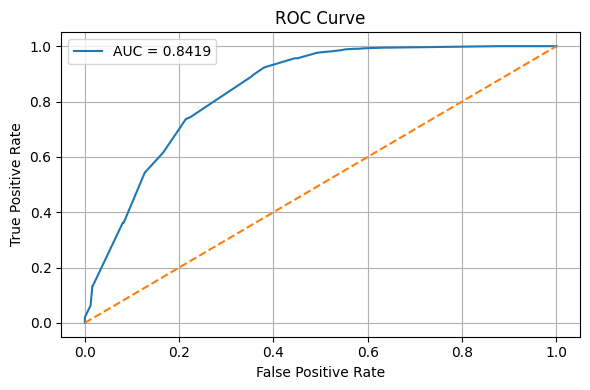

In [9]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

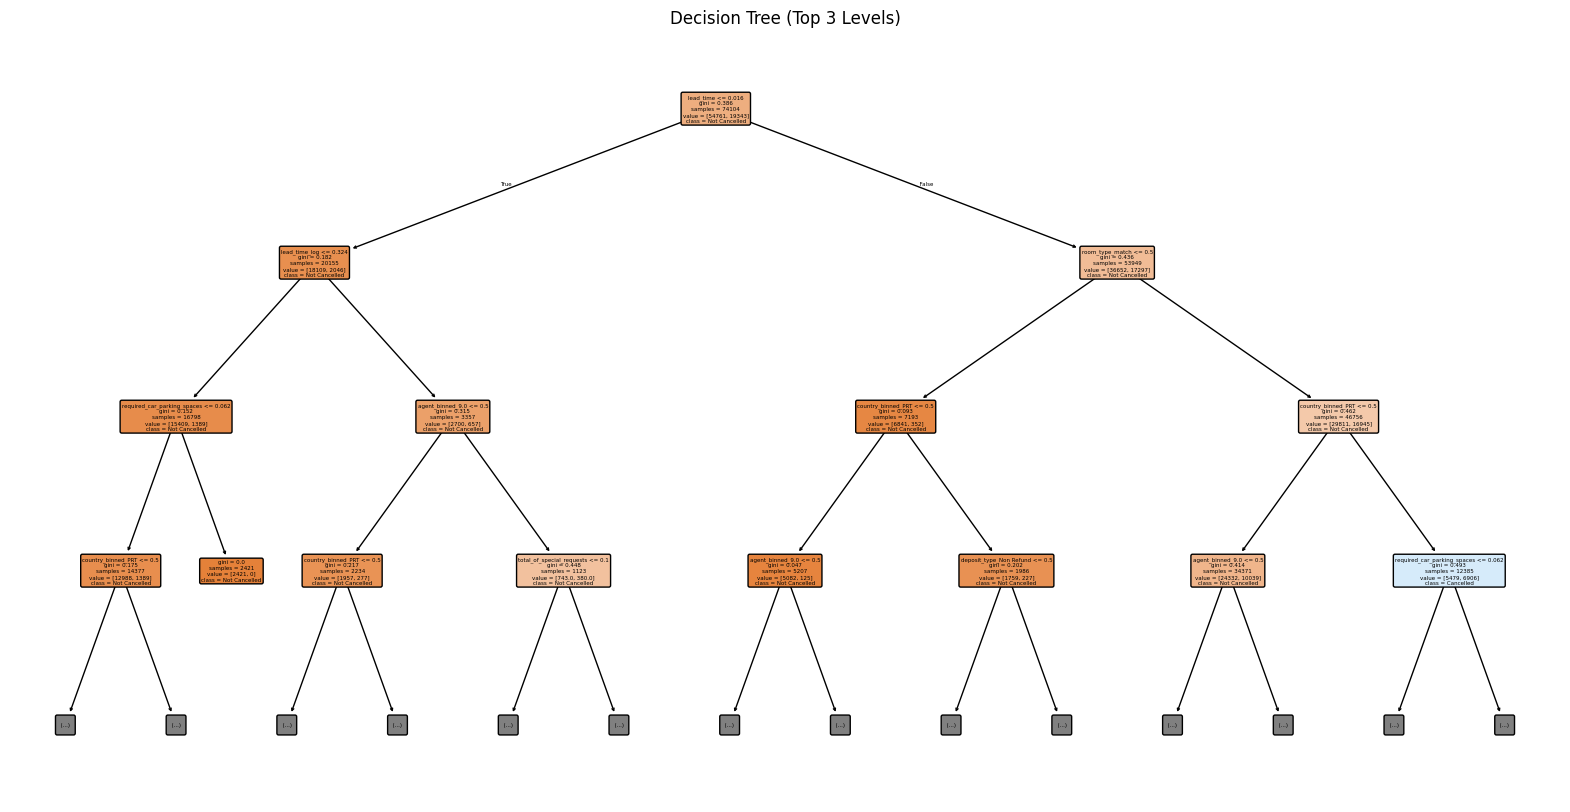

In [10]:
# Visualize the tree
levels_for_viz = 3
plt.figure(figsize=(20, 10))
plot_tree(final_model, feature_names=X_train.columns, class_names=["Not Cancelled", "Cancelled"],
          filled=True, rounded=True, max_depth=levels_for_viz)  # keep short for readability
plt.title(f"Decision Tree (Top {levels_for_viz} Levels)")
plt.show()

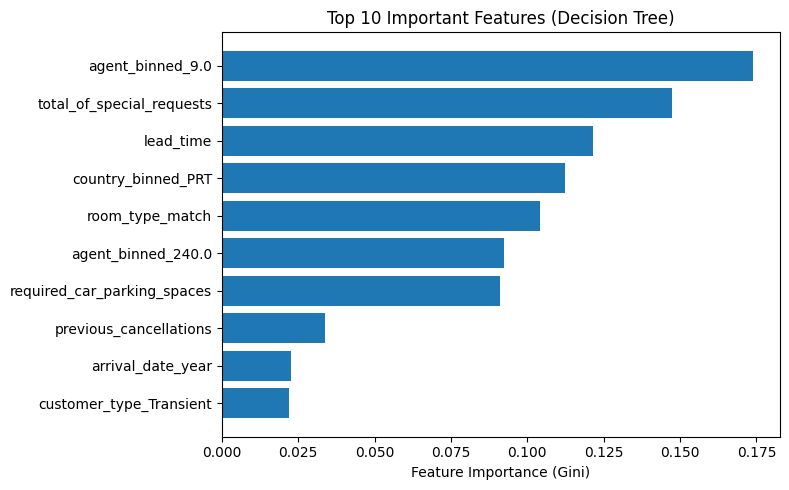

In [11]:
# Show top 10 feature importances
importances = final_model.feature_importances_
features = X_train.columns
top_idx = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(8, 5))
plt.barh(range(10), importances[top_idx][::-1])
plt.yticks(range(10), [features[i] for i in top_idx][::-1])
plt.xlabel("Feature Importance (Gini)")
plt.title("Top 10 Important Features (Decision Tree)")
plt.tight_layout()
plt.show()


## Time Series Models

In [14]:
print(list(df.columns))

['is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'arrival_date', 'arrival_date_in_3_month', 'lead_time_log', 'booking_changes_log', 'meal_bin', 'total_guests', 'room_type_match', 'hotel_City Hotel', 'hotel_Resort Hotel', 'arrival_date_month_April', 'arrival_date_month_August', 'arrival_date_month_December', 'arrival_date_month_February', 'arrival_date_month_January', 'arrival_date_month_July', 'arrival_date_month_June', 'arrival_date_month_March', 'arrival_date_month_May', 'arrival_date_month_November', 'arrival_date_month_October', 'arrival_date_month_September', 'market_segment_Aviation', 'market_segment_Complementary', 'market_segment_Corporate', 'market_segment_Direct', 'market_segme

In [12]:
# Compute daily cancellation rate features only ===
daily_cxl = df.groupby('reservation_status_date').agg(
    cancellations=('is_canceled', 'sum'),
    bookings=('is_canceled', 'count')
)
daily_cxl['cxl_rate'] = daily_cxl['cancellations'] / daily_cxl['bookings']
daily_cxl = daily_cxl.asfreq('D')
daily_cxl['cxl_rate'] = daily_cxl['cxl_rate'].ffill()

# === 3. Create rolling features and join into df ===
daily_cxl['cxl_rate_3d'] = daily_cxl['cxl_rate'].shift(1).rolling(3).mean()
daily_cxl['cxl_rate_7d'] = daily_cxl['cxl_rate'].shift(1).rolling(7).mean()

# Merge rolling features back into df
df = df.merge(daily_cxl[['cxl_rate_3d', 'cxl_rate_7d']], on='reservation_status_date', how='left')
df[['cxl_rate_3d', 'cxl_rate_7d']] = df[['cxl_rate_3d', 'cxl_rate_7d']].fillna(0)
display(df.head())

KeyError: 'reservation_status_date'

In [ ]:
# For time-based split
(X_train, y_train), (X_val, y_val), (X_test, y_test) = train_val_test_split(df, use_time_split=True)

# Use Optuna to tune the decision tree
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best hyperparameters:", study.best_params)

# Train best model on combined train+val
X_final_train = pd.concat([X_train, X_val])
y_final_train = pd.concat([y_train, y_val])

final_model = DecisionTreeClassifier(**study.best_params, random_state=42)
final_model.fit(X_final_train, y_final_train)

# Evaluate on test set
y_test_probs = final_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_test_probs)
print(f"Test AUC: {auc:.4f}")

In [ ]:
# Evaluate on test set
y_test_probs = final_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_test_probs)
print(f"Test AUC: {auc:.4f}")

In [ ]:
# Visualize the tree
levels_for_viz = 3
plt.figure(figsize=(20, 10))
plot_tree(final_model, feature_names=X_train.columns, class_names=["Not Cancelled", "Cancelled"],
          filled=True, rounded=True, max_depth=levels_for_viz)  # keep short for readability
plt.title(f"Decision Tree (Top {levels_for_viz} Levels)")
plt.show()

In [ ]:
# Show top 10 feature importances
importances = final_model.feature_importances_
features = X_train.columns
top_idx = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(8, 5))
plt.barh(range(10), importances[top_idx][::-1])
plt.yticks(range(10), [features[i] for i in top_idx][::-1])
plt.xlabel("Feature Importance (Gini)")
plt.title("Top 10 Important Features (Decision Tree)")
plt.tight_layout()
plt.show()
